In [60]:
import pandas as pd
import os
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import rc

from scipy import stats

In [61]:
def scatter(x):
    # 한글깨짐 방지
    font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
    rc('font', family=font_name)

    fig = plt.figure(figsize=(20, 10)) # 캔버스 생성
    plt.plot(dc_df["일교차"],pollution_df[x],
             linestyle='none', 
             marker='o', 
             markersize=3,
             color='blue')

    plt.title(x+",일교차 상관관계", fontsize=20)
    plt.xlabel("일교차", fontsize=14)
    plt.ylabel(x, fontsize=14)

    plt.show()


1. 대기오염농도와 일교차간의 상관관계를 파악
=> 관련이 있다면 : 두 값을 동시에 예측
=> 관련이 없다면 : 각각의 값을 예측 (v)
    
2. 각각의 값을 예측(?)



# 전처리

In [62]:
# 일평균 오염
folder = 'C:/Users/USER/folder'
files=os.listdir(folder)
files.sort()
files=files[1:]
files

pollution_df=pd.DataFrame()


for file in files:
    print(file)
    df=pd.read_csv(folder+"/"+file,encoding="utf-8")    
    df=df[df.columns[2:]].groupby(df["측정일시"]).mean()

    pollution_df=pd.concat((pollution_df,df))
    
pollution_df.reset_index(inplace=True)
pol_cols=pollution_df.columns

display(pollution_df)

일별평균대기오염도_2016.csv
일별평균대기오염도_2017.csv
일별평균대기오염도_2018.csv
일별평균대기오염도_2019.csv
일별평균대기오염도_2020.csv


,측정일시,이산화질소농도(ppm),오존농도(ppm),이산화탄소농도(ppm),아황산가스(ppm),미세먼지(㎍/㎥),초미세먼지(㎍/㎥)
0,20160101,0.049289,0.005211,0.981579,0.006079,70.736842,44.184211
1,20160102,0.046237,0.008263,0.739474,0.006132,53.789474,31.210526
2,20160103,0.051737,0.011737,0.947368,0.007289,98.861111,57.894737
3,20160104,0.030077,0.022128,0.635897,0.006282,76.205128,45.076923
4,20160105,0.029436,0.014744,0.453846,0.006051,34.333333,16.666667
...,...,...,...,...,...,...,...
1755,20201227,0.039980,0.012900,0.790000,0.004040,65.000000,41.620000
1756,20201228,0.049500,0.007560,0.860000,0.004000,61.580000,43.640000
1757,20201229,0.035940,0.011040,0.868000,0.003640,67.520000,48.060000
1758,20201230,0.013800,0.020880,0.410000,0.002800,33.600000,12.560000


In [63]:
# 일교차
dc_df=pd.read_csv("dailycross1.csv",encoding="utf-8")

dc_df.set_index("날짜",inplace=True)

# 일교차 컬럼 생성
size=len(dc_df)
L=[]
for i in range(size):
    L.append(dc_df.iloc[i]["최고기온(℃)"]-dc_df.iloc[i]["최저기온(℃)"])
    
dc_df["일교차"]=L
dc_df=dc_df[["일교차"]]

# 2020년 12월 31까지
L=list(dc_df.index)
i=L.index("2020-12-31")
dc_df=dc_df.iloc[:i+1]

for i,v in enumerate(dc_df['일교차'].isnull()):
    if v:
        dc_df["일교차"][i]=dc_df["일교차"][i-1]

dc_df

,일교차
날짜,
2016-01-01,7.3
2016-01-02,8.5
2016-01-03,4.3
2016-01-04,7.8
2016-01-05,6.3
...,...
2020-12-27,8.6
2020-12-28,7.2
2020-12-29,10.5


In [64]:
dc_df.index.astype('str')

pollution_df_date=pd.to_datetime(pollution_df["측정일시"], format='%Y%m%d')
pollution_df_date= pollution_df_date.astype('str')
print(len(list(pollution_df_date)))
print(len(list(dc_df.index)))

L = []
for i in list(dc_df.index):
    if i not in list(pollution_df_date):
        L.append(i)
print(len(L))

1760
1827
67


In [65]:
# 인덱스맞추기
pollution_df = pollution_df.astype({"측정일시": 'str'})

polSize=len(pol_cols)

for indx in L:
    temp_df=pd.DataFrame({col:["NaN"] for col in pol_cols})
    temp_df["측정일시"]=indx[:4]+indx[5:7]+indx[-2:]
    
    pollution_df=pd.concat((pollution_df,temp_df))
    pollution_df
    
pollution_df=pollution_df.set_index("측정일시")
pollution_df=pollution_df.sort_index()
display(pollution_df)


# 결측치 채우기
rSize=len(pollution_df)
cSize=len(pollution_df.columns)

for i in range(rSize):
    if pollution_df.iloc[i,0]=="NaN":
        for j in range(cSize):
            if pollution_df.iloc[i-1,j]=="NaN":
                pollution_df.iloc[i,j]=pollution_df.iloc[i+1,j]
            elif pollution_df.iloc[i+1,j]=="NaN":
                pollution_df.iloc[i,j]=pollution_df.iloc[i-1,j]
            else:
                pollution_df.iloc[i,j]=(pollution_df.iloc[i-1,j]+pollution_df.iloc[i+1,j])//2

,이산화질소농도(ppm),오존농도(ppm),이산화탄소농도(ppm),아황산가스(ppm),미세먼지(㎍/㎥),초미세먼지(㎍/㎥)
측정일시,,,,,,
20160101,0.0492895,0.00521053,0.981579,0.00607895,70.7368,44.1842
20160102,0.0462368,0.00826316,0.739474,0.00613158,53.7895,31.2105
20160103,0.0517368,0.0117368,0.947368,0.00728947,98.8611,57.8947
20160104,0.0300769,0.0221282,0.635897,0.00628205,76.2051,45.0769
20160105,0.0294359,0.0147436,0.453846,0.00605128,34.3333,16.6667
...,...,...,...,...,...,...
20201227,0.03998,0.0129,0.79,0.00404,65,41.62
20201228,0.0495,0.00756,0.86,0.004,61.58,43.64
20201229,0.03594,0.01104,0.868,0.00364,67.52,48.06


In [66]:
v=pollution_df.index[0]

print(v)



20160101


In [67]:
indx=[]
for v in pollution_df.index:
    indx.append(v[:4]+"-"+v[4:6]+"-"+v[-2:])

pollution_df=pollution_df.reset_index()
pollution_df["측정일시"]=indx
pollution_df=pollution_df.set_index("측정일시")

display(pollution_df)
# pollution_df_date=pd.to_datetime(pollution_df["측정일시"], format='%Y%m%d')

,이산화질소농도(ppm),오존농도(ppm),이산화탄소농도(ppm),아황산가스(ppm),미세먼지(㎍/㎥),초미세먼지(㎍/㎥)
측정일시,,,,,,
2016-01-01,0.0492895,0.00521053,0.981579,0.00607895,70.7368,44.1842
2016-01-02,0.0462368,0.00826316,0.739474,0.00613158,53.7895,31.2105
2016-01-03,0.0517368,0.0117368,0.947368,0.00728947,98.8611,57.8947
2016-01-04,0.0300769,0.0221282,0.635897,0.00628205,76.2051,45.0769
2016-01-05,0.0294359,0.0147436,0.453846,0.00605128,34.3333,16.6667
...,...,...,...,...,...,...
2020-12-27,0.03998,0.0129,0.79,0.00404,65,41.62
2020-12-28,0.0495,0.00756,0.86,0.004,61.58,43.64
2020-12-29,0.03594,0.01104,0.868,0.00364,67.52,48.06


# 상관분석

이산화질소농도(ppm)
상관계수 : 0.2849193950756807
p-value : 1.8283450619782671e-35


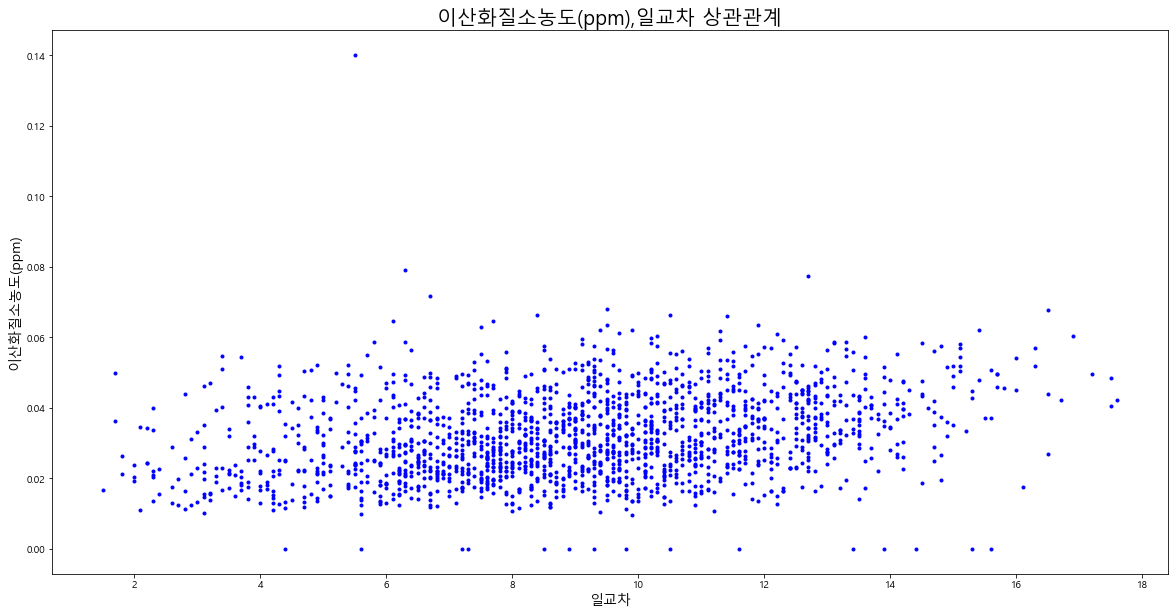

오존농도(ppm)
상관계수 : 0.17179450069104288
p-value : 1.4345817773515596e-13


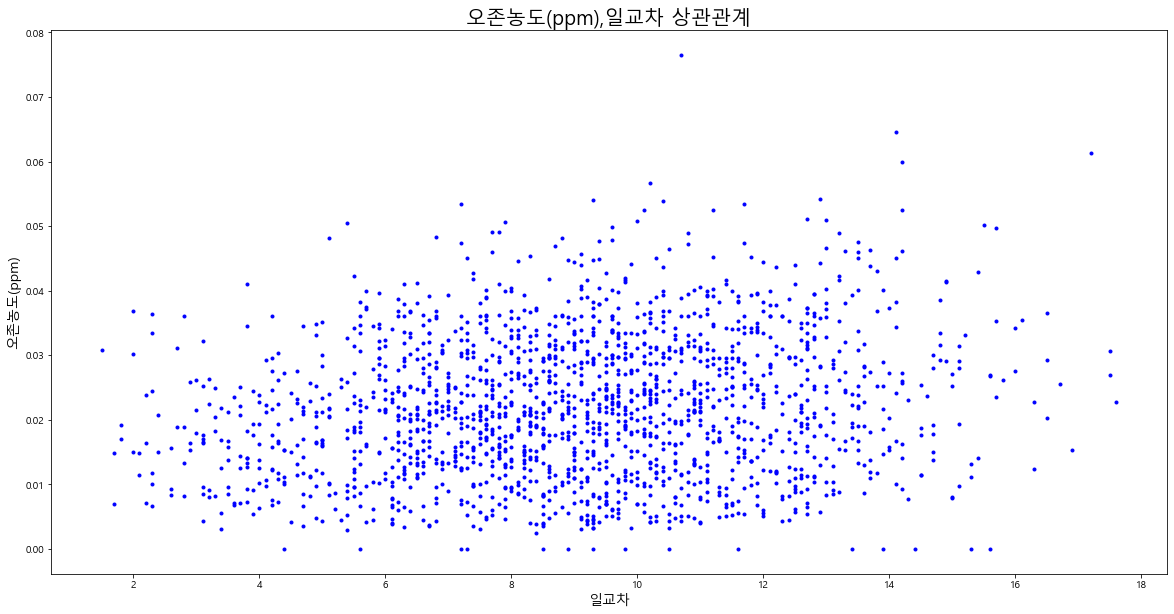

이산화탄소농도(ppm)
상관계수 : 0.13277360108069916
p-value : 1.2225523664959116e-08


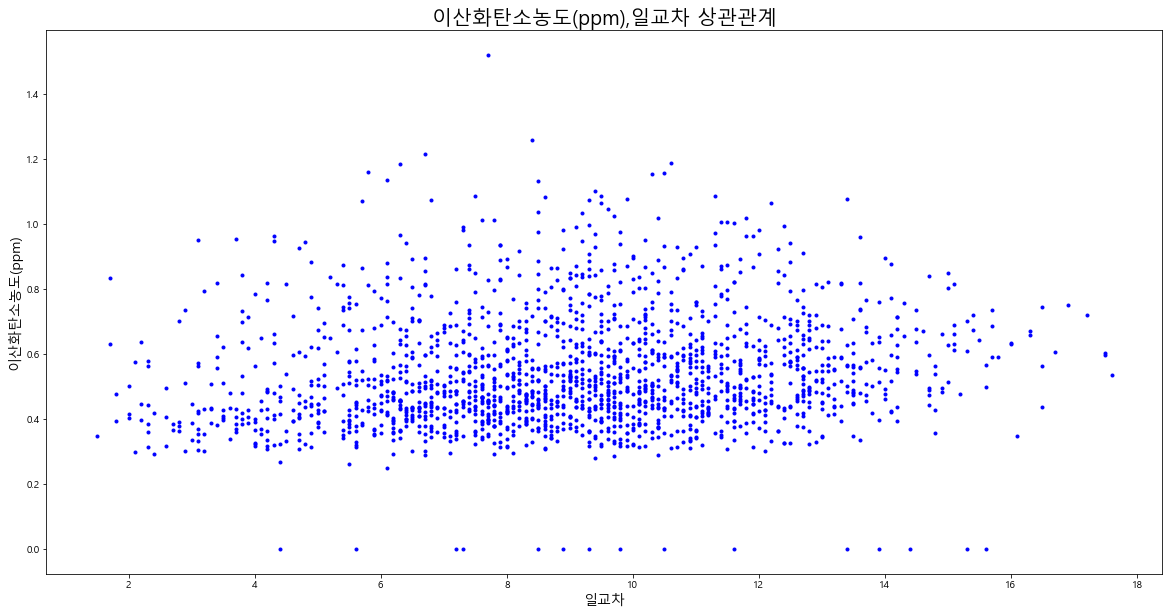

아황산가스(ppm)
상관계수 : 0.19804898617839284
p-value : 1.293576882465906e-17


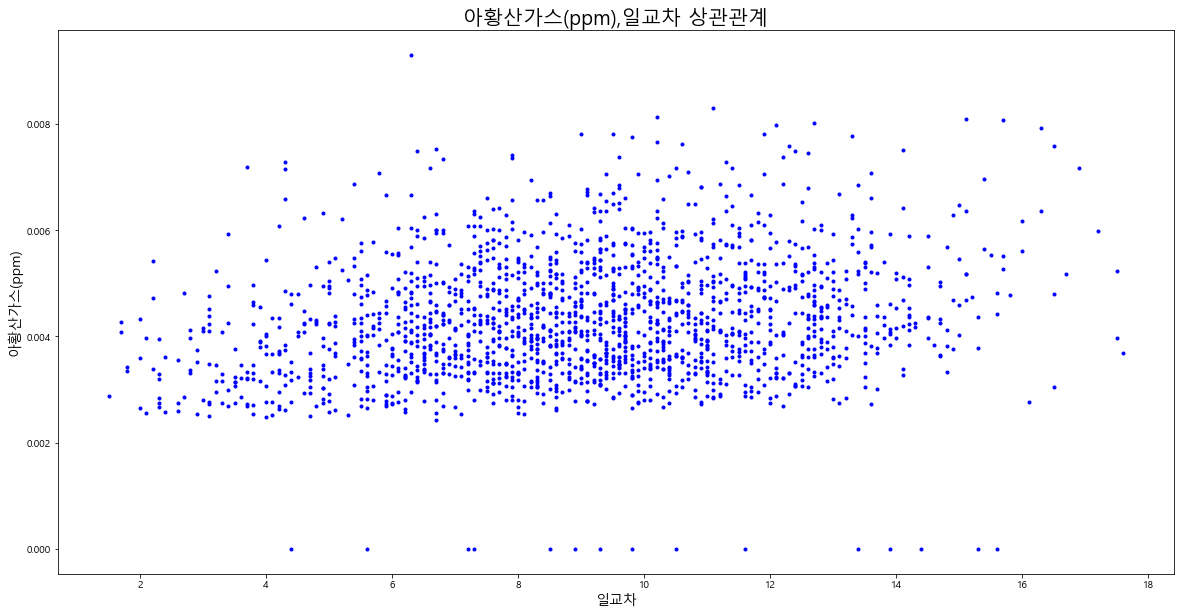

미세먼지(㎍/㎥)
상관계수 : 0.2315219651414483
p-value : 1.1741831353634886e-23


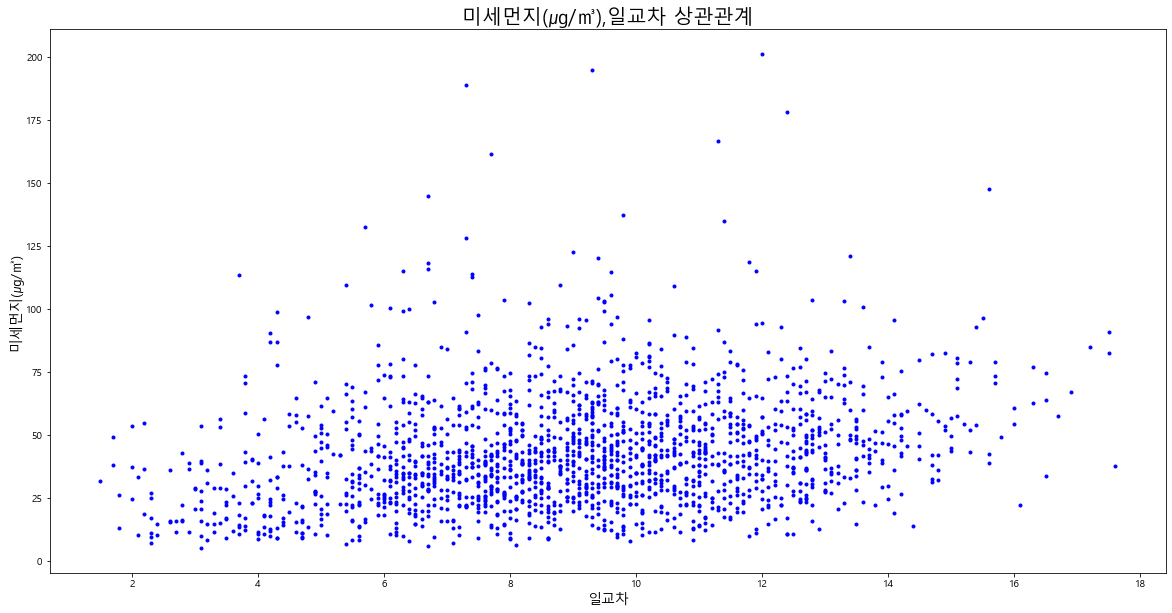

초미세먼지(㎍/㎥)
상관계수 : 0.13082503062909856
p-value : 1.997497477014614e-08


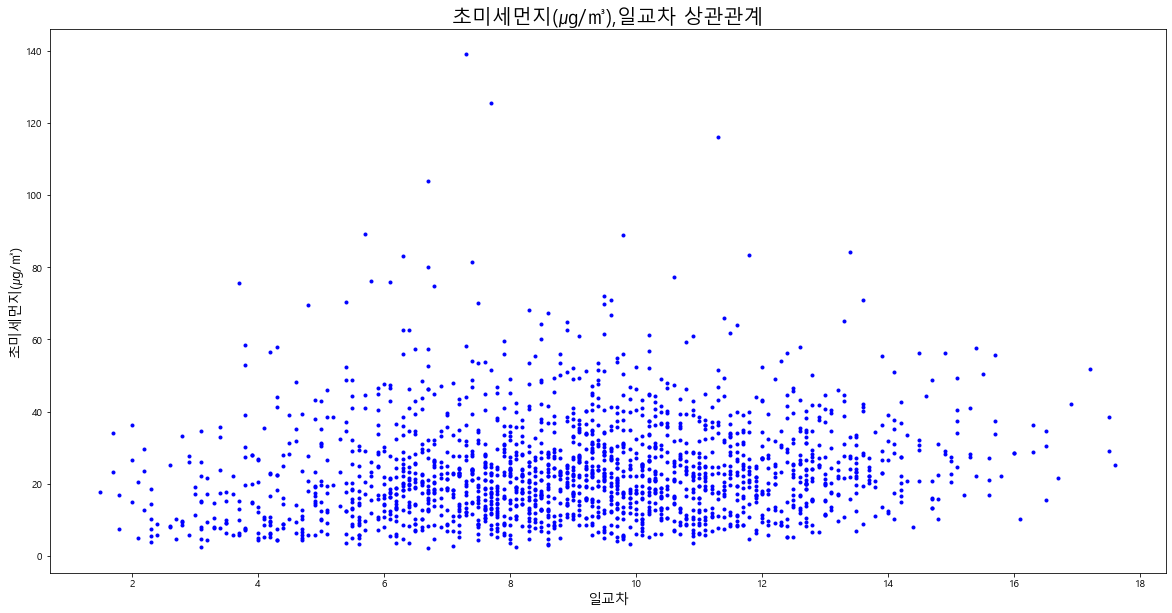

In [68]:
# concat_df.corr(method="pearson")
A=pollution_df.columns

for a in A:
    print(a)
    corr,pval=stats.pearsonr(pollution_df[a],dc_df["일교차"])
    print("상관계수 :",corr)
    print("p-value :",pval)
    scatter(a)

In [69]:
pollution_df.to_csv("pollution_df.csv")
dc_df.to_csv("dc_df.csv")